# Importing the necessary libraries

In [3]:
# !pip install zenml
# !pip install scikit-learn
# !pip install mlflow

# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

df = pd.read_csv('../data/raw/KAG_conversion_data.csv')

In [5]:
def filter_interest(df, column_name, threshold=0.8, new_column_name='filtered_interest'):
    value_counts = df[column_name].value_counts()
    total_count = value_counts.sum()
    cum_count = 0
    keep_values = []

    for value, count in value_counts.items():
        cum_count += count
        if cum_count / total_count <= threshold:
            keep_values.append(value)
        else:
            break

    filtered_df = df.copy()
    filtered_df[new_column_name] = filtered_df[column_name].apply(lambda x: x if x in keep_values else 'other')
    return filtered_df

In [6]:
df = filter_interest(df, 'interest', threshold=0.8, new_column_name='pareto_interest')
df1 = df


In [7]:
df['conv1'] = np.where(df['Total_Conversion'] != 0, 1, 0)
df['conv2'] = np.where(df['Approved_Conversion'] != 0, 1, 0)

In [ ]:
columns_to_one_hot_encode = ['pareto_interest', 'gender','age']  # Add all columns you want to encode

dis_interest = df['pareto_interest'].unique()
dis_gender = df['gender'].unique()
dis_age = df['age'].unique()


# Use get_dummies to create dummy variables for specified columns
df_dummies = pd.get_dummies(df[columns_to_one_hot_encode], prefix='', prefix_sep='')

# Convert boolean columns to integers
boolean_columns = df_dummies.select_dtypes(include='bool').columns
df_dummies[boolean_columns] = df_dummies[boolean_columns].astype(int)
df = pd.concat([df, df_dummies], axis=1)

In [ ]:
df2 = df.drop(['age', 'gender', 'xyz_campaign_id', 'fb_campaign_id', 'interest', 'pareto_interest'], axis=1).set_index('ad_id')

<Axes: ylabel='Count'>

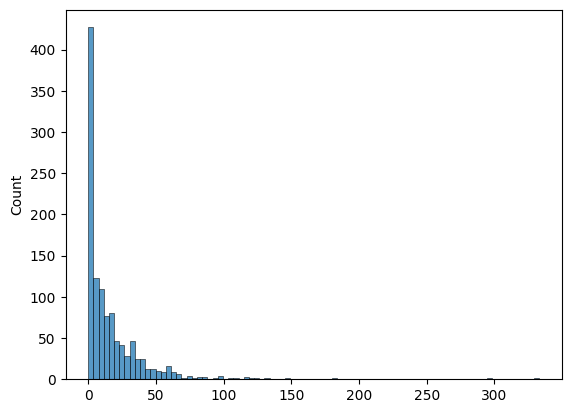

In [12]:
sns.histplot(df2['Spent'] / df2['Total_Conversion'])

In [45]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Chuẩn hóa cột 'Spent' bằng Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df2['Spent'] = scaler.fit_transform(df2[['Spent']])
df2['ROI'] = (df2['Spent'] / df2['Total_Conversion']).fillna(0)


# Chuẩn bị dữ liệu
X = df2.drop(['Total_Conversion', 'Approved_Conversion', 'conv1', 'conv2', 'Impressions', 'Clicks', 'ROI'], axis=1)
Y = df2[['ROI']]

# Chia dữ liệu thành train-test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Huấn luyện mô hình Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.fit(X_train, Y_train.values.ravel())  # .ravel() để chuyển Y từ 2D thành 1D

# Tính toán R2 score và MAPE cho tập huấn luyện
Y_train_pred = model.predict(X_train)

# Tính toán R2 score và MAPE cho tập kiểm tra
Y_test_pred = model.predict(X_test)
r2_test = r2_score(Y_test, Y_test_pred)
mape_test = mean_absolute_percentage_error(Y_test, Y_test_pred)

print(f"R2 Score for Test Set: {r2_test:.4f}")
print(f"MAPE for Test Set: {mape_test:.4f}")

# Vẽ đồ thị kết quả và tầm quan trọng của đặc trưng
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Đồ thị giá trị dự đoán vs giá trị thực tế cho tập kiểm tra
ax[0].scatter(Y_test_pred, Y_test, alpha=0.5)
ax[0].plot(Y_test, Y_test, color='red')
ax[0].set_xlabel('Predicted Values')
ax[0].set_ylabel('Actual Values')
ax[0].set_title(f'GradientBoostingRegressor Results (Test Set)\nR2 score: {r2_test:.4f}\nMAPE: {mape_test:.4f}')

# Vẽ biểu đồ tầm quan trọng của đặc trưng
feature_importance = model.feature_importances_
sorted_indices = feature_importance.argsort()[::-1]  # Sắp xếp giảm dần theo độ quan trọng
sorted_features = X.columns[sorted_indices]          # Lấy tên đặc trưng dựa trên chỉ số

ax[1].barh(range(len(feature_importance)), feature_importance[sorted_indices])
ax[1].set_yticks(range(len(feature_importance)))
ax[1].set_yticklabels(sorted_features)
ax[1].set_xlabel('Feature Importance')
ax[1].set_title('Feature Importance')

plt.tight_layout()
plt.show()


ValueError: Input y contains infinity or a value too large for dtype('float64').

In [33]:
combinations = []

# Lặp qua từng giá trị và tạo tổ hợp
for age in dis_age:
    for gender in dis_gender:
        for interest in dis_interest:
            # Thêm tổ hợp vào danh sách
            combinations.append({'age': age, 'gender': gender, 'pareto_interest': interest})

# Chuyển đổi danh sách thành DataFrame
df_combinations = pd.DataFrame(combinations)



In [34]:

# Use get_dummies to create dummy variables for specified columns
df_combinations = pd.get_dummies(df_combinations[columns_to_one_hot_encode], prefix='', prefix_sep='')

# Convert boolean columns to integers
boolean_columns = df_combinations.select_dtypes(include='bool').columns
df_combinations[boolean_columns] = df_combinations[boolean_columns].astype(int)
df_combinations.insert(0, 'Spent', 0)



In [41]:
df_combinations['Spent'] = 1000

pred = model.predict(df_combinations)

max_index = np.argmax(pred)
max_value = pred[max_index]

# Lấy cấu hình đầu vào tương ứng
best_config = df_combinations.iloc[max_index]  # Sử dụng iloc để truy xuất hàng theo chỉ số

# In ra kết quả
print(f"Cấu hình đầu vào tối ưu: {best_config}")
print(f"Giá trị Total_Conversion dự đoán tối đa: {max_value:.4f}")

Cấu hình đầu vào tối ưu: Spent    1000
10          0
15          1
16          0
18          0
19          0
20          0
21          0
22          0
25          0
26          0
27          0
28          0
29          0
30          0
31          0
32          0
63          0
64          0
other       0
F           0
M           1
30-34       1
35-39       0
40-44       0
45-49       0
Name: 0, dtype: int64
Giá trị Total_Conversion dự đoán tối đa: 59.5456


In [39]:
df.sort_values(ascending=False, by="Spent")

,ad_id,xyz_campaign_id,fb_campaign_id,age,gender,interest,Impressions,Clicks,Spent,Total_Conversion,...,32,63,64,other,F,M,30-34,35-39,40-44,45-49
525,1121100,1178,144532,30-34,M,15,3052003,340,639.949998,60,...,0,0,0,0,0,1,1,0,0,0
860,1121814,1178,144659,30-34,F,27,2223278,421,612.300003,38,...,0,0,0,0,1,0,1,0,0,0
765,1121601,1178,144624,45-49,M,16,2286228,353,603.380002,16,...,0,0,0,0,0,1,0,0,0,1
1026,1122265,1178,144734,45-49,F,27,1428421,367,541.700002,10,...,0,0,0,0,1,0,0,0,0,1
995,1122193,1178,144722,45-49,F,10,1358324,346,465.079998,8,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,710628,916,104230,30-34,F,18,1473,0,0.000000,1,...,0,0,0,0,1,0,1,0,0,0
41,710682,916,104239,30-34,F,27,1186,0,0.000000,1,...,0,0,0,0,1,0,1,0,0,0
44,710867,916,104270,30-34,F,63,1185,0,0.000000,1,...,0,1,0,0,1,0,1,0,0,0
51,711785,916,104423,45-49,F,19,292,0,0.000000,1,...,0,0,0,0,1,0,0,0,0,1


In [44]:
df2[df2['Total_Conversion'] == 0]

,Impressions,Clicks,Spent,Total_Conversion,Approved_Conversion,conv1,conv2,10,15,16,...,63,64,other,F,M,30-34,35-39,40-44,45-49,ROI
ad_id,,,,,,,,,,,,,,,,,,,,,
735033,652,0,0.000000,0,0,0,0,0,0,0,...,0,0,1,1,0,0,1,0,0,NaN
747968,512,0,0.000000,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,NaN
776476,43756,5,0.008501,0,0,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,inf
951853,529,0,0.000000,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,NaN
1121352,368986,59,0.156715,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,inf
1121820,11471,1,0.002453,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,inf
1122146,319501,79,0.174467,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,inf
1122182,40801,12,0.024877,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,inf
